In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('E commerce Dataset', index_col = 0)

In [3]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress        

#### EDA

In [5]:
del df['CustomerID']

In [6]:
cat_cols = df.dtypes[df.dtypes == 'object'].index

for i in cat_cols:
    print(f'{i} --> {df[i].unique()}')
    print()

PreferredLoginDevice --> ['Mobile Phone' 'Phone' 'Computer']

PreferredPaymentMode --> ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']

Gender --> ['Female' 'Male']

PreferedOrderCat --> ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

MaritalStatus --> ['Single' 'Divorced' 'Married']



In [7]:
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace('Phone', 'Mobile Phone')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD':'Cash on Delivery'})
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace('Mobile', 'Mobile Phone')

In [8]:
cat_cols = df.dtypes[df.dtypes == 'object'].index

for i in cat_cols:
    print(f'{i} --> {df[i].unique()}')
    print()

PreferredLoginDevice --> ['Mobile Phone' 'Computer']

PreferredPaymentMode --> ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']

Gender --> ['Female' 'Male']

PreferedOrderCat --> ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

MaritalStatus --> ['Single' 'Divorced' 'Married']



In [9]:
df.isnull().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

Tenure, WarehouseToHome, HourSpendOnApp, DaySinceLastOrder:

- Эти переменные являются количественными и важны для анализа поведения клиентов. Заполним пропуски медианой, так как она менее подвержена влиянию выбросов, чем среднее.

In [10]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['HourSpendOnApp'] = df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].median())
df['WarehouseToHome'] = df['WarehouseToHome'].fillna(df['WarehouseToHome'].median())
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())

OrderAmountHikeFromlastYear, CouponUsed, OrderCount:

- Эти переменные связаны с заказами и покупками. Для них также применим медиану, поскольку она помогает скорректировать влияние выбросов.

In [11]:
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(df['OrderAmountHikeFromlastYear'].median())
df['CouponUsed'] = df['CouponUsed'].fillna(df['CouponUsed'].median())
df['OrderCount'] = df['OrderCount'].fillna(df['OrderCount'].median())

- Давайте отвечаем на этот вопрос почему клиенты уходять

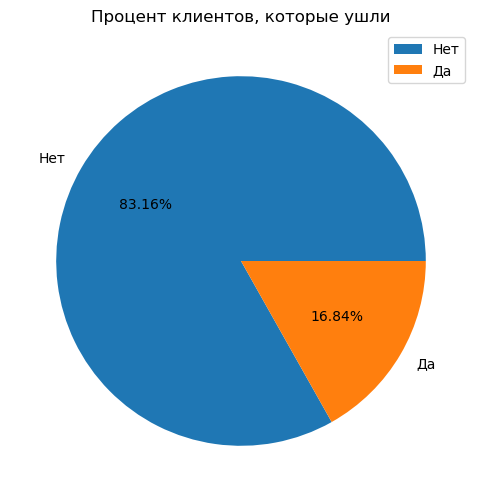

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [15,6])

percent_count = df['Churn'].value_counts(normalize = True)
ax.pie(x = df['Churn'].value_counts(),labels = ["Нет", "Да"], autopct = lambda percent_count: '{:.2f}%'.format(percent_count))
ax.set_title('Процент клиентов, которые ушли', fontsize = 12)
ax.legend()

plt.show()

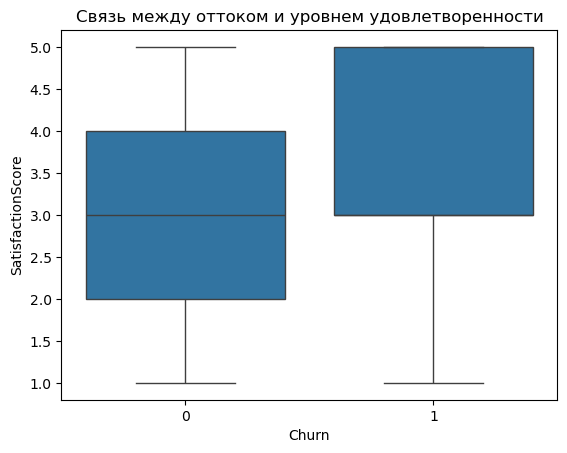

In [13]:
sns.boxplot(x="Churn", y="SatisfactionScore", data=df)
plt.title("Связь между оттоком и уровнем удовлетворенности")
plt.show()

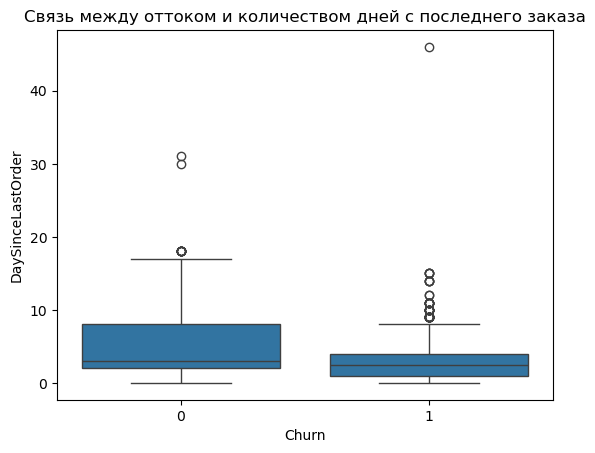

In [14]:
sns.boxplot(x="Churn", y="DaySinceLastOrder", data=df)
plt.title("Связь между оттоком и количеством дней с последнего заказа")
plt.show()

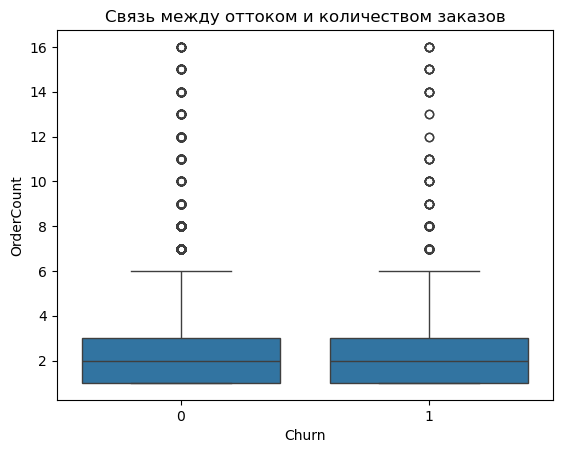

In [15]:
sns.boxplot(x="Churn", y="OrderCount", data=df)
plt.title("Связь между оттоком и количеством заказов")
plt.show()

- Количество заказов не является сильным фактором, влияющим на отток – ушедшие и оставшиеся клиенты заказывают примерно одинаково.

In [16]:
num_columns = df.select_dtypes(include = ['int', 'float'])
churn_group = num_columns.groupby('Churn').mean()
churn_group

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
Churn,,,,,,,,,,,,,
0,11.404528,1.619821,15.305639,2.928663,3.639257,3.001282,4.162965,0.234088,15.686032,1.718069,2.992952,4.709739,180.635203
1,3.859705,1.827004,16.856540,2.964135,3.934599,3.390295,4.466245,0.535865,15.618143,1.710970,2.808017,3.222574,160.370928


- Tenure(Время в компании) - Ушедшие клиенти в среднем остаются в компании в 3 раза меньше. Нужно улучшить программу адаптации и удержания новых клиентов
- CityTier (Уровень города) - Ушедшие клиенты чаще живут в более высокоуровенных городах. Возмозно им больше альтернатив.
- WarehouseToHome (расстояние от склада до дома) - Ушедшие клиенты живут дальше от складов. Можеть быть, доставка занимает больше времени?
- HourSpendOnApp (часы в предложении) - Использование приложения не сильно влияет на отток.
- NumberOfDeviceRegistered (устройств на аккаунте) - Ушедшие клиенты используют чуть больше устройств. Возможно, они тестириют сервис, но не задерживаются.
- SatisfactionScore(уровень удовлетворенности) - Ушедшие клиенты имеют чуть выше средний балл. Это странно. Нужно проверить распределение оценок.
- NumberOfAddress (адреса в аккаунте) - Ушедшие клиенты добавляют больше адресов. Можеть, они часто переезжают с другими сервисами.
- Complain (был ли возврат или жалоба) - Серьезная разница! Ушедшие клиенты в 2 раза чаще жалуются! Это сильный фактор оттока. Нужно улучшить клиентский сервис.
- OrderAmountHikeFromLastYear (рост заказов с прошлого года) - разница минимальная
- CouponUsed (количество использованных купонов) - Купоны не влияют на отток.
- OrderCount (количество заказов в месяць) - Ушедшие клиенты делают чуть меньше заказов. Возможно, они используют сервис нерегулярно.
- DaySinceLastOrder (дни с последнего заказа) - Ушедшие клиенты делали заказы недавно, но все равно ушли.
- CashbackAmount (кэшбэк) - Оставшиенся клиенты получают больше кэшбэка. Может, это помогает их удерживать?

#### Ключевые инсайты
- Новые клиенты уходять чаще --> Нужно фокусироваться на удержании в первые месяцы (Tenure)
- Жалобы - главный фактор оттока --> Улучшить поддержку и скорость решения проблем (Complain)
- Клиенты из отдельных районов уходять чаще --> Возможно, из-за долгой доставки (WarehouseToHome)
- Малое количество заказов --> риск оттока --> Нужно предлагать акции, персонализированные предложения (OrderCount)
- Cashback можеть удерживать клиентов --> Стоить протестировать увеличенные бонусы для тех, кто в зоне риска.

#### Гипотеза: Ушедшие клиенты имеют более низкий уровень удовлетворенности

- 📊 H₀ (нулевая гипотеза): Средний SatisfactionScore одинаков у ушедших (Churn = 1) и оставшихся (Churn = 0) клиентов.
- 📊 H₁ (альтернативная гипотеза): SatisfactionScore ниже у ушедших клиентов.

In [17]:
from scipy.stats import ttest_ind

satisfaction_churn = df[df['Churn'] == 1]['SatisfactionScore']
satisfaction_no_churn = df[df['Churn'] == 0]['SatisfactionScore']

t_stat, p_value = ttest_ind(satisfaction_churn, satisfaction_no_churn, equal_var = False)
print(f'T - статистика: {t_stat}, P-значение: {p_value}')

T - статистика: 8.10123175509438, P-значение: 1.1847878426006565e-15


- t-тест (студенческий t-тест) — это статистический метод, который сравнивает средние значения двух групп, чтобы понять, есть ли значимая разница между ними.
- p-значение (p-value) — это вероятность того, что разница между группами возникла случайно.
Если p-значение < 0.05, то разница значима, и мы отвергаем нулевую гипотезу.

##### Из этих тестов мы можем сделать такой вывод
- Средний уровень удовлетворенности (SatisfactionScore) у ушедших клиентов значительно ниже, чем у оставшихся. Это значить, что неудовлетворенные клиенты чаще уходять!

##### Что с ним делать?
- Улучшить сервис и качество клиентов.
- Дать бонусы
- Улучшить поддержку

###### Гипотеза:
- H₀ (нулевая гипотеза): Жалобы (Complain) не связаны с оттоком.
- H₁ (альтернативная гипотеза): Клиенты, у которых были жалобы, уходят чаще.

In [18]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df["Churn"], df["Complain"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Хи-квадрат: {chi2}, P-значение: {p}")

Хи-квадрат: 350.92545525927073, P-значение: 2.6644609654641377e-78


###### Интерпретация теста
- Хи-квадрат = 350.93 → очень большое значение, значит, есть сильная разница между группами.
- P-значение = 2.66e-78 → это практически 0, то есть вероятность случайного совпадения нулевая.

##### Вывод
- Жалобы действительно связаны с оттоком клиентов!
- Клиенты, которые подают жалобы, значительно чаще уходять!

##### Что с ним делать ?
- Улучшить качество обслуживания, чтобы снизить число жалоб.
- Быстрее реагировать на жалобы
- Предлагать скидки или бонусы
- Анализировать причины жалоб и устранять их заранее.

###### Гипотеза:
- H₀ (нулевая гипотеза): Среднее расстояние от склада до дома не отличается у ушедших и оставшихся клиентов.
- H₁ (альтернативная гипотеза): Среднее расстояние различается, и ушедшие клиенты жили дальше.

In [19]:
churned = df[df["Churn"] == 1]["WarehouseToHome"]
not_churned = df[df["Churn"] == 0]["WarehouseToHome"]

t_stat, p_value = ttest_ind(churned, not_churned, equal_var=False)
print(f"T-статистика: {t_stat}, P-значение: {p_value}")

T-статистика: 5.249428583165697, P-значение: 1.7678496584551714e-07


##### Интерпретация теста:
- T-статистика = 5.25 → говорит о том, что есть разница между группами.
- P-значение = 1.76e-07 → очень маленькое, разница статистически значима.

- Это значение не очень влияеть на оттока клиентов

#### Корреляция

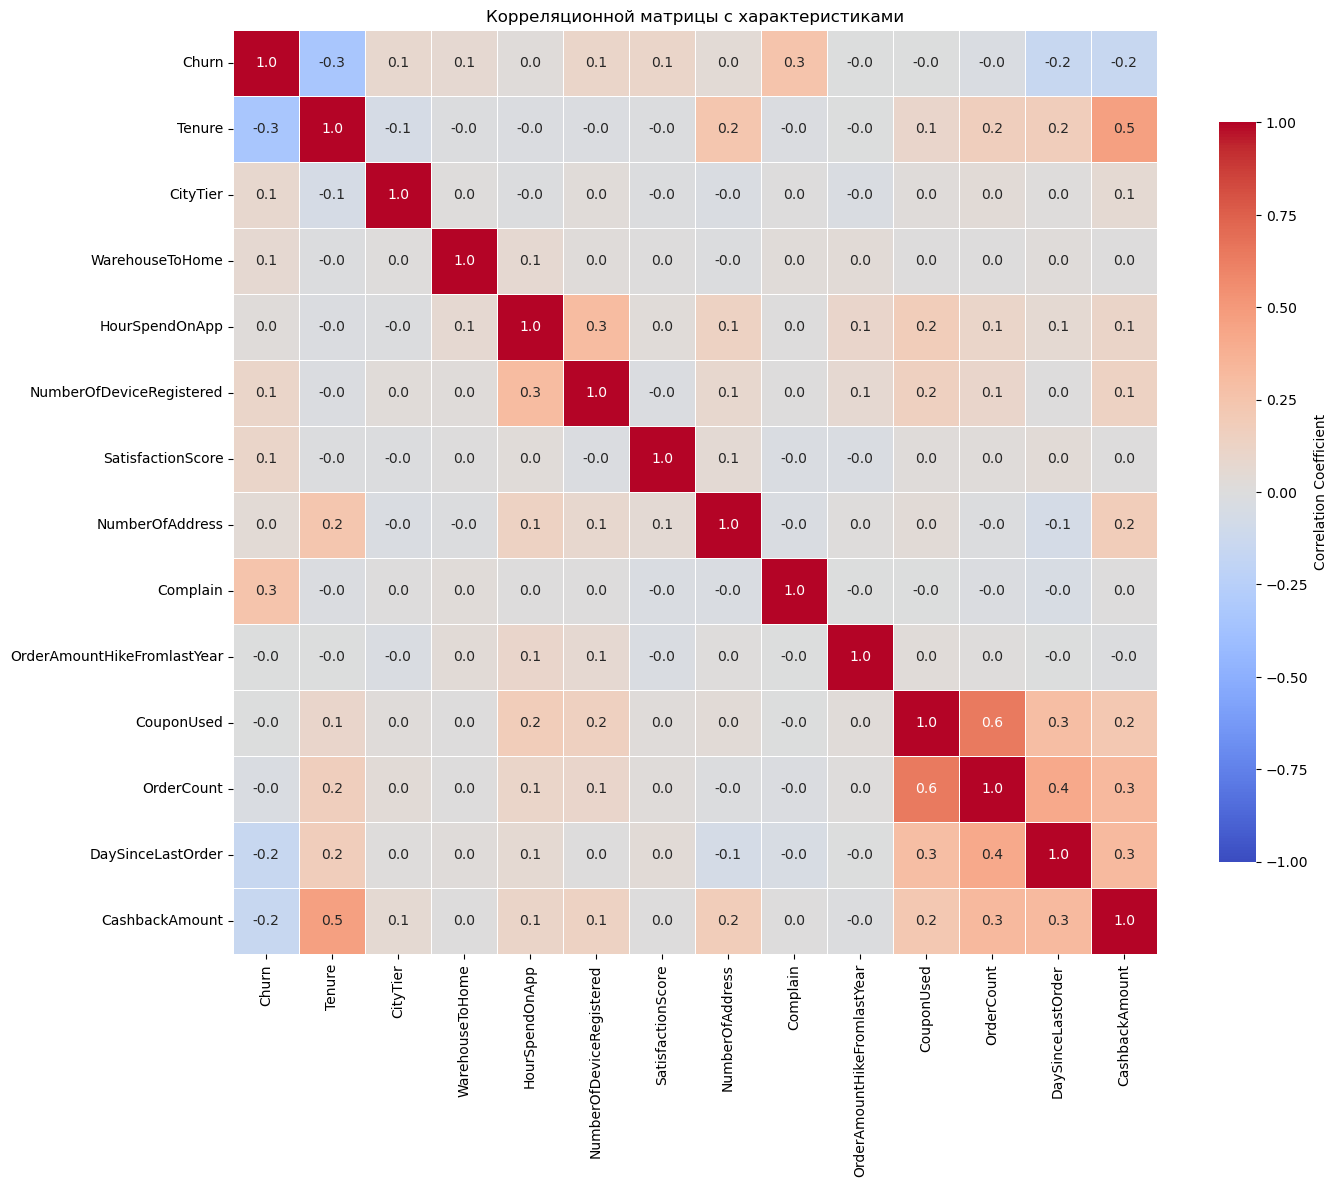

In [20]:
corrmat = num_columns.corr()
fig = plt.figure(figsize = (16, 12))
sns.heatmap(
    corrmat, 
    annot=True,  # Добавляет значения корреляции
    fmt=".1f",   # Формат значений (2 знака после запятой)
    cmap="coolwarm",  # Цветовая палитра
    vmax=1.0,    # Максимальное значение
    vmin=-1.0,   # Минимальное значение
    square=True, # Квадратные ячейки
    linewidths=0.5, # Толщина линий между ячейками
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}  # Настройка цветовой шкалы
)
plt.title('Корреляционной матрицы с характеристиками')
plt.show()

In [21]:
num_columns.corrwith(df['Churn'])

Churn                          1.000000
Tenure                        -0.337831
CityTier                       0.084703
WarehouseToHome                0.069544
HourSpendOnApp                 0.018816
NumberOfDeviceRegistered       0.107939
SatisfactionScore              0.105481
NumberOfAddress                0.043931
Complain                       0.250188
OrderAmountHikeFromlastYear   -0.007075
CouponUsed                    -0.001430
OrderCount                    -0.024038
DaySinceLastOrder             -0.155871
CashbackAmount                -0.154118
dtype: float64

##### One-Hot Encoding

In [22]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_columns = encoder.fit_transform(df.select_dtypes(include=['object']))

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out())
data_encoded_one = df.drop(columns=df.select_dtypes(include=['object']).columns)
df = pd.concat([data_encoded_one, encoded_df], axis=1)

df.head()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1,4.0,3,6.0,3.0,3,2,9,1,11.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,9.0,1,8.0,3.0,4,3,7,1,15.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,9.0,1,30.0,2.0,4,3,6,1,14.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0.0,3,15.0,2.0,4,5,8,0,23.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,0.0,1,12.0,3.0,3,5,3,0,11.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


##### Train_test_split

In [23]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4504, 25)
(1126, 25)
(4504,)
(1126,)


##### StandardScaler

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Logistic Regression model

Accuracy: 0.9129662522202486
ROC_AUC: 0.8980153373352098


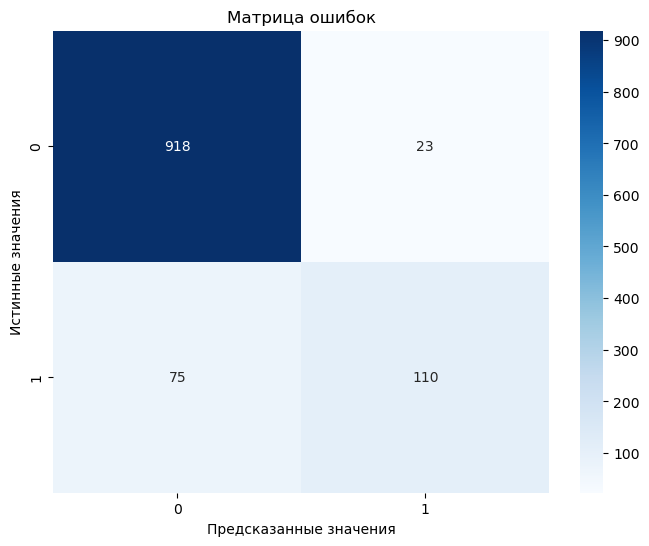

In [25]:
LR_model = LogisticRegression(max_iter = 1000, random_state=42)
LR_model.fit(X_train, y_train)

y_pred_lr = LR_model.predict(X_test)
y_pred_lr_proba = LR_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc_lr_proba = roc_auc_score(y_test, y_pred_lr_proba)

print(f"Accuracy: {accuracy}")
print(f"ROC_AUC: {roc_auc_lr_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

##### Decision Tree

Accuracy: 0.9103019538188277
ROC_AUC: 0.8874170663756211


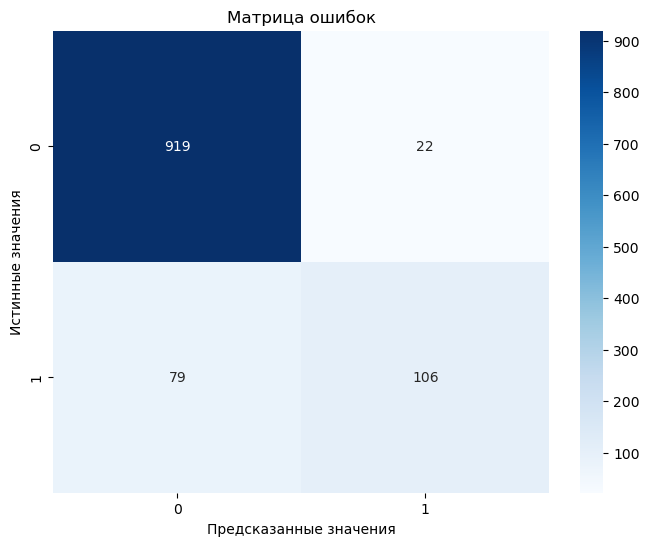

In [26]:
tree_model = DecisionTreeClassifier(max_depth=6)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_pred_tree_proba = tree_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_tree)
roc_auc_tree_proba = roc_auc_score(y_test, y_pred_tree_proba)

print(f"Accuracy: {accuracy}")
print(f"ROC_AUC: {roc_auc_tree_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_tree)
recall = recall_score(y_test, y_pred_tree)
f1 = f1_score(y_test, y_pred_tree)

In [27]:
RF_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model_rf = grid_search.best_estimator_

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


Accuracy: 0.972
ROC_AUC: 0.9919091248528018


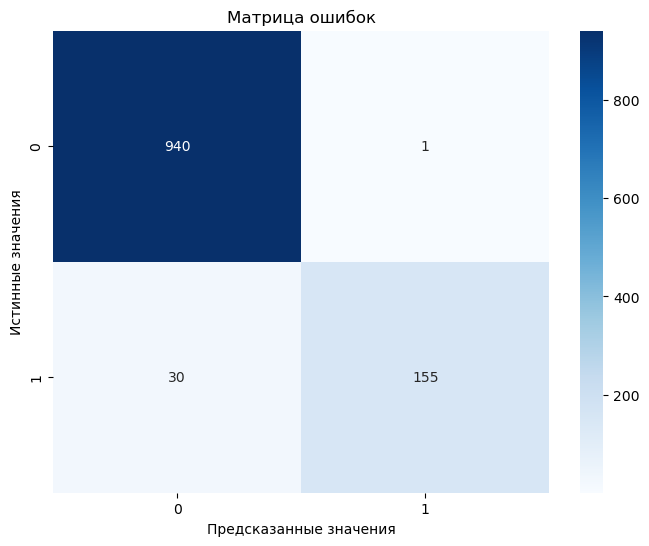

In [28]:
y_pred_forest = best_model_rf.predict(X_test)
y_pred_forest_proba = best_model_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_tree)
roc_auc_forest_proba = roc_auc_score(y_test, y_pred_forest_proba)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred_forest))
print(f"ROC_AUC: {roc_auc_forest_proba}")

conf_matrix = confusion_matrix(y_test, y_pred_forest)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

precision = precision_score(y_test, y_pred_forest)
recall = recall_score(y_test, y_pred_forest)
f1 = f1_score(y_test, y_pred_forest)

##### Рекомендации для снижения оттока клиентов
- Рекомендация по послепродажному обслуживанию: Этот онлайн магазин специализируется на продаже компьютеров, телефонов и другой техники, что делает эти товары ценными для клиентов. Рекомендуется после каждой покупки собирать номер клиента и в течение недели связываться с ним, чтобы узнать, как работает купленная техника. Если клиент сталкивается с проблемами, предоставить ему рекомендации и помощь. Это поможет укрепить доверие клиентов и повысить вероятность того, что они вернутся за следующей покупкой.

- Акции для новых клиентов: Большинство клиентов уходят в первые месяцы. Рекомендуется предложить привлекательные акции для новых клиентов, основываясь на исследовании конкурентов, чтобы повысить удержание.

- Сбор обратной связи и гибкие тарифы: Активно собирать обратную связь от уходящих клиентов и предложить гибкие тарифы для пользователей в городах с низким уровнем удовлетворенности.

- Регулярное взаимодействие с новыми клиентами: Проводить регулярные взаимодействия с новыми пользователями через персонализированные предложения и бонусы, чтобы повысить их лояльность и мотивировать к рекомендациям.

- Оптимизация логистики: Улучшить логистику и ускорить доставку для клиентов, находящихся далеко от складов, чтобы снизить отток.